In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.metrics import confusion_matrix
from matplotlib import pylab as plt
from sklearn.metrics import confusion_matrix
from matplotlib import pylab as pl

from sklearn.model_selection import train_test_split

In [2]:
targetAttribute = 'Poisonous/Edible'
defaultTargetValue = 'p'
minimalGainThreshold = 0.144 # maxInfoGain : 0.144354902043
#targetAttribute = ''
targetValue = []

In [3]:
# data class to hold csv data
def entropy(df):
    # target unique value calculation in form of dictionary
    targetDict = pd.value_counts(df[targetAttribute]).to_dict()
    dfLength = len(df)

    totalEntropy = 0
    # print(targetDict)
    for key, val in targetDict.items():
        multipleVal = val / dfLength
        totalEntropy += multipleVal * math.log2(multipleVal)

    return 0 - totalEntropy


#add values to targetValue
def initializeList(data):
    groupedData = data.groupby([targetAttribute]).groups.keys()
    return groupedData


In [4]:
def calcInforGainForEachAtrribute(df):
    # return maximum info gain
    maxInfoGain = 0;
    infoGainDict = {}
    attributes = list(df)
    totalEntropy = entropy(df)

    for att in attributes:
        # don't calculate gain for target attribute
        if (att == targetAttribute):
            continue
        grouped_data = df.groupby([att], as_index=False)
        totalRows = len(df)
        subEntropy = 0
        # print('keys for ', att, ' total- ', totalRows)

        for key, value in grouped_data:
            eachGroupRows = len(value)
            # print('key-', key, ' eachGroupRows- ', eachGroupRows)

            S = entropy(value)

            # calculate |Sv/S|
            valEntrpy = eachGroupRows / totalRows

            # calculate |Sv/S|*Entropy(Sv)
            subEntropy = subEntropy + valEntrpy * S

        individualEntrpyGain = totalEntropy - subEntropy
        infoGainDict[att] = individualEntrpyGain
        # print('gain-', att, ' - ', individualEntrpyGain)
        if (individualEntrpyGain > maxInfoGain):
            maxInfoGain = individualEntrpyGain
            maxGainAttr = att;

    # If there's no gain at all, nothing has to be done, just return the original set
    if (maxInfoGain < minimalGainThreshold):
        # print("in maxInfoGain")
        # print(maxInfoGain,maxGainAttr)
        print("maxGainAttr: ", maxGainAttr)
        print("maxInfoGain :", maxInfoGain)
        return None, None
    else:
        return maxGainAttr, maxInfoGain


In [5]:
def trueSet(s):
    return len(set(s)) == 1


def createTree(df):
    x = df.drop(labels=targetAttribute, axis=1)
    y = df[targetAttribute]

    # If there could be no split, just return the original set
    if len(y) == 0:
        return y

    if trueSet(y):
        return set(y).pop()

    # We get attribute that gives the highest mutual information

    maxGainAttr, maxInfoGain = calcInforGainForEachAtrribute(df)

    if ((maxGainAttr == None) and (maxInfoGain == None)):
        return defaultTargetValue

    # We split using the selected attribute
    sets = df.groupby(maxGainAttr)
    # print(sets)

    # print(type(sets))
    res = {}
    for k, v in sets:
        res["%s = %s" % (maxGainAttr, k)] = createTree(v)

    return res


In [6]:
def predictTarget(targetDict,test):
    for k,v in targetDict.items():
        keyList = k.split('=')
        col = keyList[0].strip()
        val = keyList[1].strip()
        if(test[col].iloc[0] == val):
            if k in targetDict:
                temp = targetDict.get(k)
                if(type(temp) == dict):
                    return predictTarget(v,test)
                else:
                    return v




def printMatrix(y_test,predictedList,labels):
    cm = confusion_matrix(y_test, pd.Series(predictedList), labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    pl.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    pl.xlabel('Predicted')
    pl.ylabel('True')
    pl.show()

In [7]:
def main():
    # df = pd.read_excel("MushroomDataSet_After_PreProcessing.xlsx")

    # datasetAfterProcessing = pd.read_excel('MushroomDataSet_After_PreProcessing.xlsx')
    # split_value = (int) (len(datasetAfterProcessing.index)*0.8)
    # training_data = pd.DataFrame(datasetAfterProcessing.iloc[:split_value,:].values)
    # training_data.columns= ['Poisonous/Edible','cap-shape','cap-surface','cap-color','bruises?','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring	','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color',	'population','habitat']

    datasetAfterProcessing = pd.read_excel('../data/MushroomDataSet_After_PreProcessing.xlsx')
    X = datasetAfterProcessing.drop(labels=targetAttribute, axis=1)
    y = datasetAfterProcessing[targetAttribute]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train[targetAttribute] = y_train
    targetValue = initializeList(X_train)

    #targetDict = createTree(X_train)
    targetDict = createTree(X_train)
    print(targetDict)
    '''
    expected output -
    {'odor = a': 'e', 'odor = c': 'p', 'odor = f': 'p', 'odor = l': 'e', 'odor = m': 'p', 'odor = n': {'spore-print-color = b': 'e', 'spore-print-color = h': 'e', 'spore-print-color = k': 'e', 'spore-print-color = n': 'e', 'spore-print-color = o': 'e', 'spore-print-color = r': 'p', 'spore-print-color = w': {'habitat = d': {'gill-size = b': 'e', 'gill-size = n': 'p'}, 'habitat = g': 'e', 'habitat = l': {'cap-color = c': 'e', 'cap-color = n': 'e', 'cap-color = w': 'p', 'cap-color = y': 'p'}, 'habitat = p': 'e', 'habitat = w': 'e'}, 'spore-print-color = y': 'e'}, 'odor = p': 'p', 'odor = s': 'p', 'odor = y': 'p'}

    '''

    predictedList = []
    for i in list(range(0, len(X_test))):
        predictedVal = predictTarget(targetDict, X_test.iloc[[i]])
        predictedList.append(predictedVal)

    printMatrix(y_test, predictedList, list(targetValue))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


{'odor = a': 'e', 'odor = c': 'p', 'odor = f': 'p', 'odor = l': 'e', 'odor = m': 'p', 'odor = n': {'spore-print-color = b': 'e', 'spore-print-color = h': 'e', 'spore-print-color = k': 'e', 'spore-print-color = n': 'e', 'spore-print-color = o': 'e', 'spore-print-color = r': 'p', 'spore-print-color = w': {'habitat = d': {'gill-size = b': 'e', 'gill-size = n': 'p'}, 'habitat = g': 'e', 'habitat = l': {'cap-color = c': 'e', 'cap-color = n': 'e', 'cap-color = w': 'p', 'cap-color = y': 'p'}, 'habitat = p': 'e', 'habitat = w': 'e'}, 'spore-print-color = y': 'e'}, 'odor = p': 'p', 'odor = s': 'p', 'odor = y': 'p'}
[[843   0]
 [  0 782]]


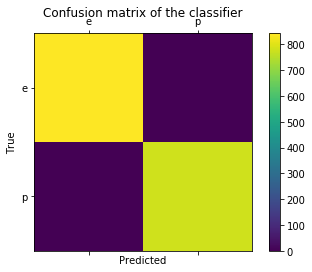

In [8]:
main()